In [47]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import time
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.font_manager as fm

In [48]:
# 利用可能なフォント一覧を取得
available_fonts = [f.name for f in fm.fontManager.ttflist]

# 日本語フォントを表示
print([font for font in available_fonts if "Japanese" in font or "Meiryo" in font or "Noto" in font])

['Noto Sans Multani', 'Noto Sans Vai', 'Noto Sans Gunjala Gondi', 'Noto Sans Khudawadi', 'Noto Sans Hatran', 'Noto Sans New Tai Lue', 'Noto Sans Yi', 'Noto Serif Balinese', 'Noto Sans Bhaiksuki', 'Noto Sans Mende Kikakui', 'Noto Sans Kayah Li', 'Noto Sans Psalter Pahlavi', 'Noto Sans Sharada', 'Noto Serif Ahom', 'Noto Sans Lycian', 'Noto Sans Kharoshthi', 'Noto Sans Old South Arabian', 'Noto Sans Ugaritic', 'Noto Sans Avestan', 'Noto Sans Sundanese', 'Noto Sans Carian', 'Noto Sans Egyptian Hieroglyphs', 'Noto Sans Glagolitic', 'Noto Sans Thaana', 'Noto Sans Osage', 'Noto Sans Chakma', 'Noto Sans Syloti Nagri', 'Noto Sans Modi', 'Noto Sans Mahajani', 'Noto Sans Old Italic', 'Noto Sans Tifinagh', 'Noto Sans Takri', 'Noto Sans Siddham', 'Noto Sans Caucasian Albanian', 'Noto Serif Yezidi', 'Noto Sans Armenian', 'Noto Sans Buhid', 'Noto Nastaliq Urdu', 'Noto Serif Myanmar', 'Noto Sans Bamum', 'Noto Sans Linear A', 'Noto Sans Kaithi', 'Noto Sans Javanese', 'Noto Sans Cuneiform', 'Noto Sans M

In [49]:
def create_suumo_url(base_url, conditions):
    """条件に基づいてURLを生成する関数"""
    url = base_url
    
    # 家賃条件
    if conditions.get('min_rent'):
        url += f"&cb={conditions['min_rent']}"
    if conditions.get('max_rent'):
        url += f"&ct={conditions['max_rent']}"
    
    # 間取り条件
    madori_codes = {
        '1R': 'mdg01', '1K': 'mdg02', '1DK': 'mdg03', '1LDK': 'mdg04',
        '2K': 'mdg05', '2DK': 'mdg06', '2LDK': 'mdg07',
        '3K': 'mdg08', '3DK': 'mdg09', '3LDK': 'mdg10',
        '4K': 'mdg11', '4DK': 'mdg12', '4LDK': 'mdg13'
    }
    
    if conditions.get('madori'):
        for m in conditions['madori']:
            if m in madori_codes:
                url += f"&{madori_codes[m]}=1"
    
    # 専有面積条件
    if conditions.get('min_size'):
        url += f"&mb={conditions['min_size']}"
    if conditions.get('max_size'):
        url += f"&mt={conditions['max_size']}"
    
    return url

In [50]:
def scrape_suumo(url):
    data = []
    page = 1
    
    headers = {
        'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'
    }
    
    while True:
        try:
            page_url = f"{url}&page={page}"
            response = requests.get(page_url, headers=headers)
            soup = BeautifulSoup(response.content, 'html.parser')
            
            items = soup.find_all('div', class_='cassetteitem')
            
            if not items:
                break
                
            for item in items:
                try:
                    # 建物名
                    building_name = item.find('div', class_='cassetteitem_content-title')
                    building_name = building_name.text.strip() if building_name else "情報なし"
                    
                    # 交通情報（駅からの距離）
                    station_div = item.select_one('.cassetteitem_detail-text')
                    station_info = station_div.text.strip() if station_div else "情報なし"
                    
                    # 部屋情報
                    rooms = item.find_all('table', class_='cassetteitem_other')
                    
                    for room in rooms:
                        try:
                            # 家賃
                            rent_element = room.select_one('.cassetteitem_other-emphasis')
                            rent = rent_element.text.strip() if rent_element else "情報なし"
                            
                            # 間取り
                            madori_element = room.select_one('.cassetteitem_madori')
                            floor_plan = madori_element.text.strip() if madori_element else "情報なし"
                            
                            # 面積
                            size_element = room.select_one('.cassetteitem_menseki')
                            size = size_element.text.strip() if size_element else "情報なし"
                            
                            data.append({
                                '建物名': building_name,
                                '駅からの距離': station_info,
                                '家賃': rent,
                                '間取り': floor_plan,
                                '面積': size
                            })
                        except (AttributeError, IndexError) as e:
                            print(f"Error processing room info: {e}")
                            continue
                            
                except Exception as e:
                    print(f"Error processing item: {e}")
                    continue
            
            print(f"Page {page} processed successfully")
            page += 1
            time.sleep(1)
            
        except Exception as e:
            print(f"Error processing page {page}: {e}")
            break
    
    return pd.DataFrame(data)

In [51]:
def analyze_station_distance(df, stations):
    """駅からの距離を分析する関数"""
    station_analysis = []
    for _, row in df.iterrows():
        station_info = row['駅からの距離']
        for station in stations:
            if station in station_info:
                distance = station_info[station_info.find(station):]
                walk_time = ''
                if '徒歩' in distance:
                    walk_time = distance[distance.find('徒歩')+2:distance.find('分')]
                station_analysis.append({
                    '駅名': station,
                    '物件名': row['建物名'],
                    '徒歩分数': walk_time,
                    '家賃': row['家賃']
                })
    return pd.DataFrame(station_analysis)

In [52]:
def save_to_sqlite(df, db_name='suumo_properties.db', table_name='properties'):
    """データをSQLiteデータベースに保存する関数"""
    try:
        conn = sqlite3.connect(db_name)
        cursor = conn.cursor()

        create_table_query = f'''
        CREATE TABLE IF NOT EXISTS {table_name} (
            id INTEGER PRIMARY KEY AUTOINCREMENT,
            building_name TEXT,
            station_info TEXT,
            rent REAL,
            floor_plan TEXT,
            size REAL
        )
        '''
        cursor.execute(create_table_query)

        df = df.rename(columns={
            '建物名': 'building_name',
            '駅からの距離': 'station_info',
            '家賃': 'rent',
            '間取り': 'floor_plan',
            '面積': 'size'
        })

        df.to_sql(table_name, conn, if_exists='append', index=False)

        conn.commit()
        conn.close()

        print(f"Data successfully saved to {db_name}, table: {table_name}")
    except Exception as e:
        print(f"Error saving to SQLite: {e}")

In [56]:
# メイン処理
def main():
    # 検索条件の設定
    conditions = {
        'madori': ['ワンルーム', '1K'],  # 希望する間取り
        'max_size': 25,  # 最大面積 (m²)
        'stations': ['大井町', '品川シーサイド', '天王洲アイル', '東京テレポート', '大井町']  # フィルタリングしたい駅名
    }

    # 基本となるURL
    base_url = "https://suumo.jp/jj/chintai/ichiran/FR301FC001/?ar=030&bs=040&ra=013&cb=0.0&ct=9999999&et=9999999&cn=9999999&mb=0&mt=9999999&shkr1=03&shkr2=03&shkr3=03&shkr4=03&fw2=&ek=009014660&ek=009025630&ek=009025440&ek=009053940&ek=009005480&rn=0090"

    # URLの生成とスクレイピング
    search_url = create_suumo_url(base_url, conditions)
    df = scrape_suumo(search_url)

    if not df.empty:
        try:
            # 数値データの整形
            df['家賃'] = df['家賃'].replace('情報なし', '0')
            df['家賃'] = df['家賃'].str.replace('万円', '').astype(float)
            
            df['面積'] = df['面積'].replace('情報なし', '0')
            df['面積'] = df['面積'].str.replace('m2', '').astype(float)
            
            # 駅名でフィルタリング
            if 'stations' in conditions:
                station_filter = df['駅からの距離'].apply(
                    lambda x: any(station in x for station in conditions['stations'])
                )
                df = df[station_filter]
            
            # その他の条件でフィルタリング
            df = df[
                (df['間取り'].isin(conditions['madori'])) &
                (df['面積'] <= conditions['max_size'])
            ]
            
            # 結果をCSVファイルとして保存
            df.to_csv('suumo_filtered_properties.csv', index=False, encoding='utf-8-sig')
            
            # 結果の表示
            print("\nFirst 5 rows of the filtered data:")
            print(df.head())
            print(f"\nTotal number of properties matching criteria: {len(df)}")
            
            # 駅ごとの物件数を表示
            print("\nProperties count by station:")
            station_counts = df['駅からの距離'].apply(
                lambda x: next((station for station in conditions['stations'] if station in x), 'Other')
            ).value_counts()
            print(station_counts)
            
            # 駅からの距離の分析
            station_analysis_df = analyze_station_distance(df, conditions['stations'])
            print("\nStation Distance Analysis:")
            print(station_analysis_df.head())
            
            # 統計情報の表示
            print("\nSummary Statistics:")
            print(df.describe())
            
            # SQLiteデータベースに保存
            save_to_sqlite(df)
            
        except Exception as e:
            print(f"Error processing final data: {e}")
    else:
        print("No data was collected")

if __name__ == "__main__":
    main()

Page 1 processed successfully
Page 2 processed successfully
Page 3 processed successfully
Page 4 processed successfully
Page 5 processed successfully
Page 6 processed successfully
Page 7 processed successfully
Page 8 processed successfully
Page 9 processed successfully
Page 10 processed successfully
Page 11 processed successfully
Page 12 processed successfully
Page 13 processed successfully
Page 14 processed successfully
Page 15 processed successfully
Page 16 processed successfully
Page 17 processed successfully
Page 18 processed successfully
Page 19 processed successfully
Page 20 processed successfully
Page 21 processed successfully
Page 22 processed successfully
Page 23 processed successfully
Page 24 processed successfully
Page 25 processed successfully
Page 26 processed successfully
Page 27 processed successfully
Page 28 processed successfully
Page 29 processed successfully
Page 30 processed successfully
Page 31 processed successfully
Page 32 processed successfully
Page 33 processed

Japanese font settings applied


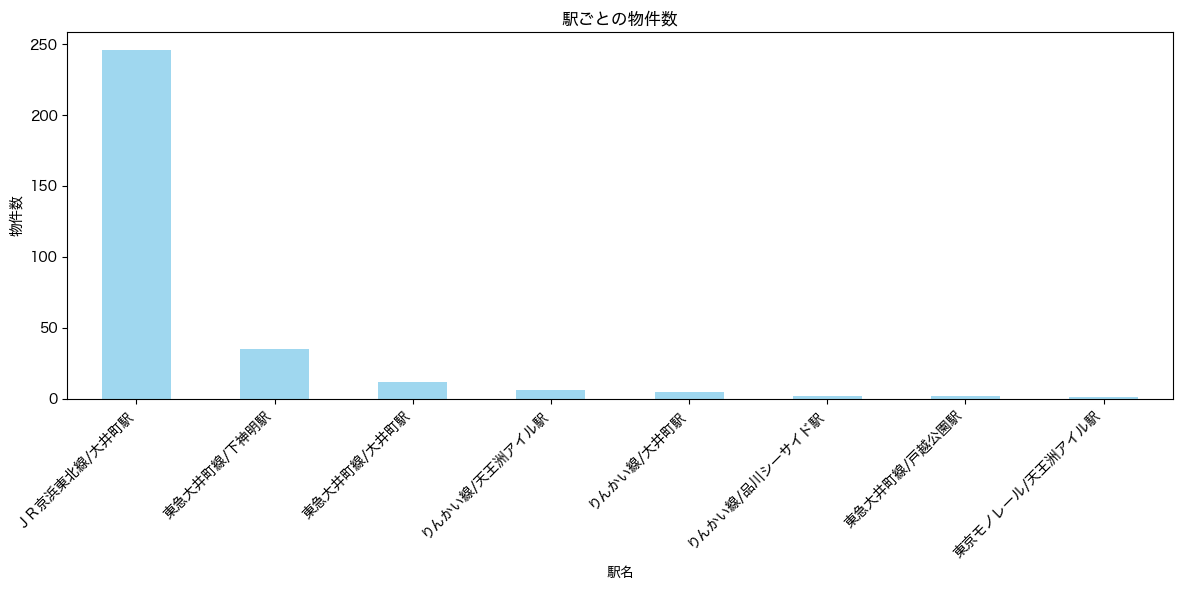

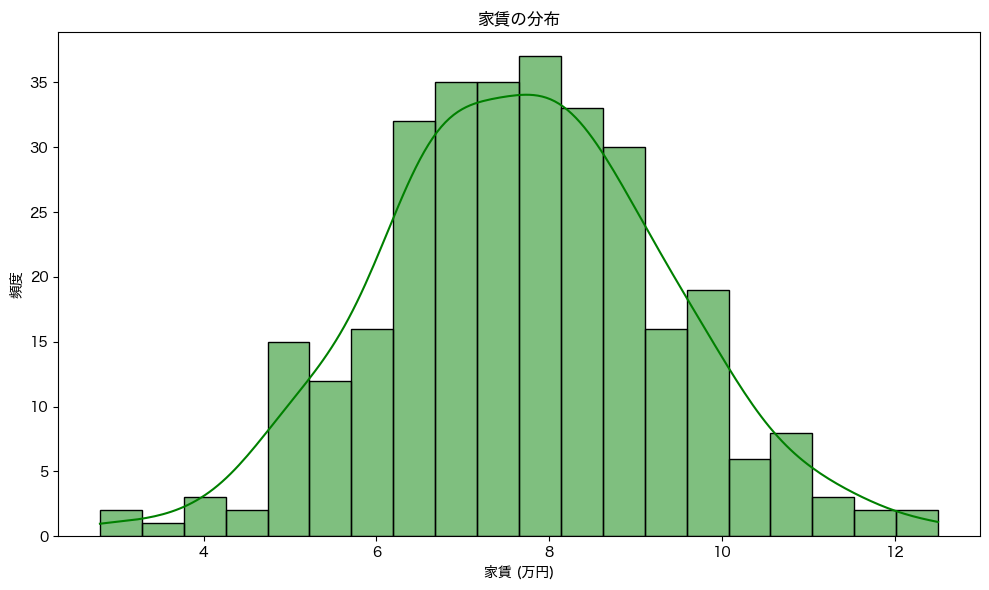

Error generating graphs: 'station_distance'


In [58]:
def plot_graphs_from_db(db_name='suumo_properties.db', table_name='properties'):
    try:
        # データベースからデータを読み取る
        conn = sqlite3.connect(db_name)
        query = f"SELECT * FROM {table_name}"
        df = pd.read_sql_query(query, conn)
        conn.close()

        # データの整形
        df['rent'] = df['rent'].astype(float)
        df['size'] = df['size'].astype(float)

        # 駅からの距離を数値に変換する関数
        def extract_minutes(distance_str):
            try:
                # "徒歩X分" から数字だけを抽出
                return float(distance_str.split('徒歩')[1].replace('分', ''))
            except:
                return None

        # 駅ごとの物件数をプロット
        df['station_name'] = df['station_info'].apply(lambda x: x.split(' ')[0] if ' ' in x else x)
        station_counts = df['station_name'].value_counts()

        plt.figure(figsize=(12, 6))
        station_counts.plot(kind='bar', color='skyblue', alpha=0.8)
        plt.title('駅ごとの物件数')
        plt.xlabel('駅名')
        plt.ylabel('物件数')
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()

        # 家賃分布をプロット
        plt.figure(figsize=(10, 6))
        sns.histplot(df['rent'], kde=True, bins=20, color='green')
        plt.title('家賃の分布')
        plt.xlabel('家賃 (万円)')
        plt.ylabel('頻度')
        plt.tight_layout()
        plt.show()

        # 駅からの距離を数値データとして抽出
        df['walking_minutes'] = df['station_distance'].apply(lambda x: extract_minutes(x.split(' ')[1]) if ' ' in x else None)

    except Exception as e:
        print(f"Error generating graphs: {e}")

# 日本語フォントを設定してからグラフを作成
set_japanese_font()
plot_graphs_from_db()

Japanese font settings applied


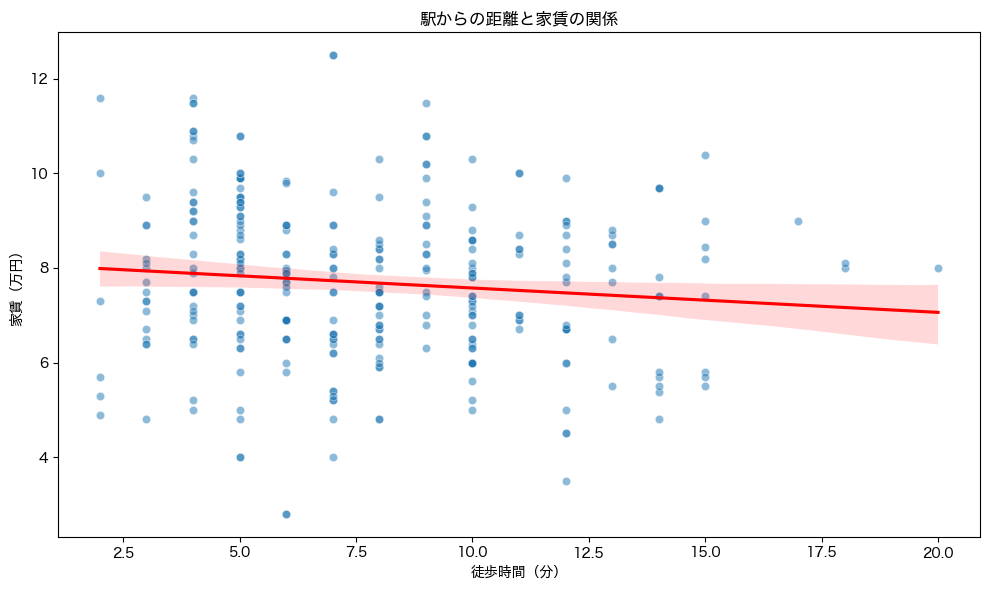

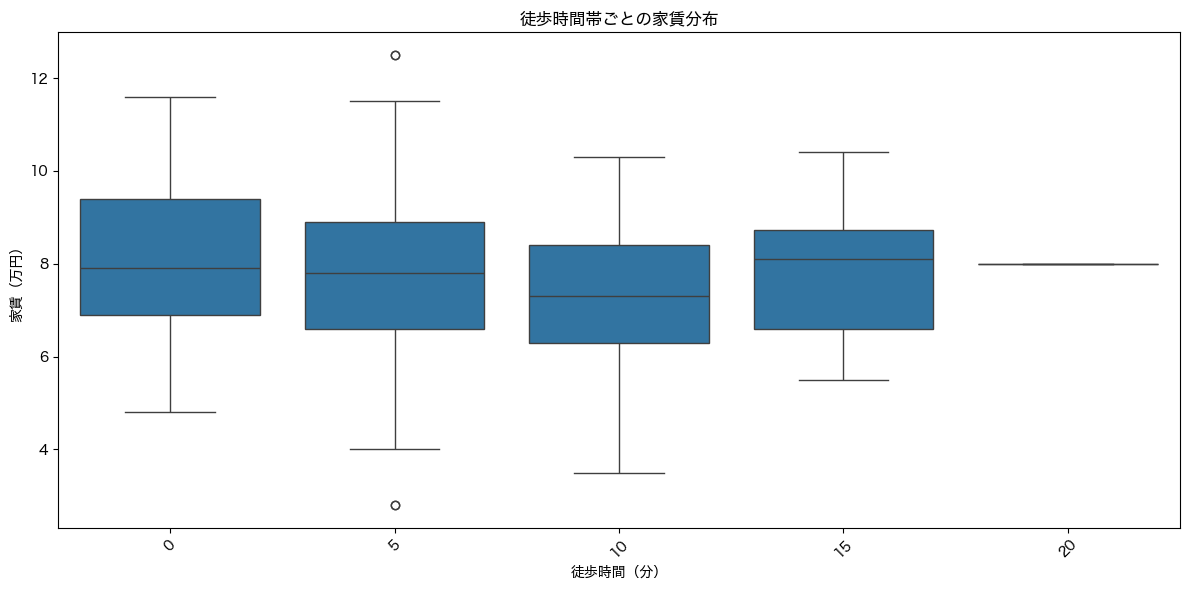


=== データ分析結果 ===
総データ数: 309
有効データ数: 309

徒歩時間の統計:
count    309.000000
mean       7.773463
std        3.455723
min        2.000000
25%        5.000000
50%        7.000000
75%       10.000000
max       20.000000
Name: walking_minutes, dtype: float64

家賃の統計:
count    309.000000
mean       7.691230
std        1.669388
min        2.800000
25%        6.500000
50%        7.700000
75%        8.800000
max       12.500000
Name: rent, dtype: float64


In [ ]:
def plot_graphs_from_db(db_name='suumo_properties.db', table_name='properties'):
    try:
        # データベースからデータを読み取る
        conn = sqlite3.connect(db_name)
        query = f"SELECT * FROM {table_name}"
        df = pd.read_sql_query(query, conn)
        conn.close()

        # データの整形
        df['rent'] = df['rent'].astype(float)

        # 駅からの距離を数値に変換する関数
        def extract_minutes(distance_str):
            try:
                # 文字列から数字を抽出
                import re
                numbers = re.findall(r'\d+', str(distance_str))
                if numbers:
                    return float(numbers[0])
                return None
            except:
                return None

        # 駅からの距離を数値データとして抽出
        df['walking_minutes'] = df['station_info'].apply(extract_minutes)

        # NaNを含まない有効なデータのみを抽出
        valid_df = df.dropna(subset=['walking_minutes', 'rent']).copy()
        
        # 数値型に変換
        valid_df['walking_minutes'] = valid_df['walking_minutes'].astype(float)
        valid_df['rent'] = valid_df['rent'].astype(float)

        # 徒歩時間を5分間隔でグループ化
        valid_df['time_group'] = (valid_df['walking_minutes'] // 5 * 5).astype(int)
        
        # 箱ひげ図
        plt.figure(figsize=(12, 6))
        sns.boxplot(data=valid_df, x='time_group', y='rent')
        plt.title('徒歩時間帯ごとの家賃分布')
        plt.xlabel('徒歩時間（分）')
        plt.ylabel('家賃（万円）')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

        # データの分析結果を表示
        print("\n=== データ分析結果 ===")
        print(f"総データ数: {len(df)}")
        print(f"有効データ数: {len(valid_df)}")
        print("\n徒歩時間の統計:")
        print(valid_df['walking_minutes'].describe())
        print("\n家賃の統計:")
        print(valid_df['rent'].describe())

    except Exception as e:
        print(f"Error generating graphs: {e}")
        import traceback
        print(traceback.format_exc())

# 日本語フォントを設定してからグラフを作成
set_japanese_font()
plot_graphs_from_db()

Japanese font settings applied


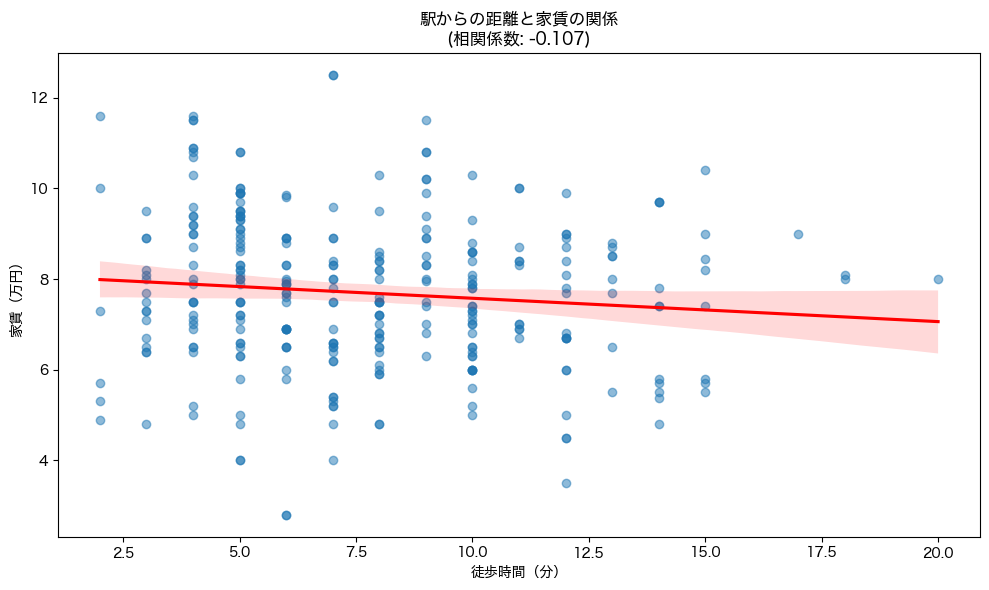

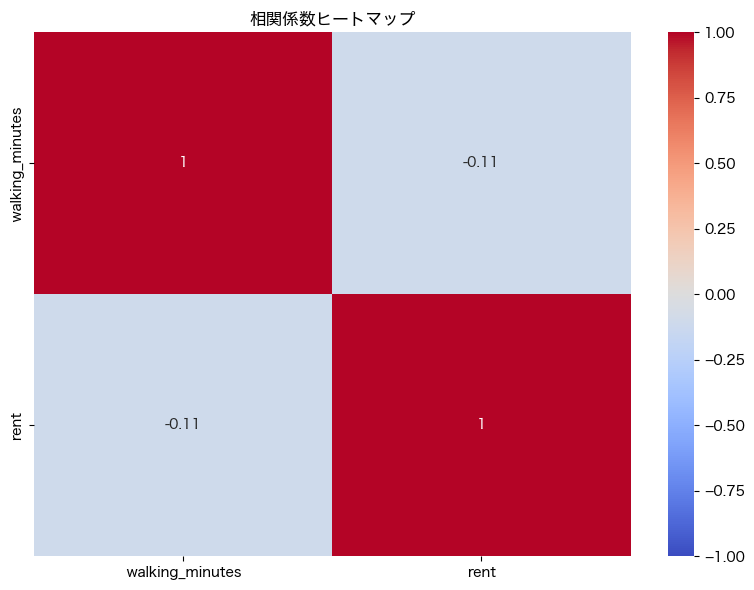


=== 相関分析結果 ===
データ数: 309

1. ピアソンの相関係数:
相関係数: -0.107
p値: 6.107e-02

2. スピアマンの順位相関係数:
相関係数: -0.123
p値: 3.112e-02

3. 相関の解釈:
ピアソン相関の強さ: ほとんど相関なし
スピアマン相関の強さ: ほとんど相関なし

4. 単回帰分析結果:
傾き: -0.052
切片: 8.092
決定係数 (R²): 0.011
p値: 6.107e-02


In [64]:
def analyze_correlation_from_db(db_name='suumo_properties.db', table_name='properties'):
    try:
        # データベースからデータを読み取る
        conn = sqlite3.connect(db_name)
        query = f"SELECT * FROM {table_name}"
        df = pd.read_sql_query(query, conn)
        conn.close()

        # データの整形
        df['rent'] = df['rent'].astype(float)

        # 駅からの距離を数値に変換する関数
        def extract_minutes(distance_str):
            try:
                import re
                numbers = re.findall(r'\d+', str(distance_str))
                if numbers:
                    return float(numbers[0])
                return None
            except:
                return None

        # 駅からの距離を数値データとして抽出
        df['walking_minutes'] = df['station_info'].apply(extract_minutes)

        # NaNを含まない有効なデータのみを抽出
        valid_df = df.dropna(subset=['walking_minutes', 'rent']).copy()
        
        # 数値型に変換
        valid_df['walking_minutes'] = valid_df['walking_minutes'].astype(float)
        valid_df['rent'] = valid_df['rent'].astype(float)

        # 1. ピアソンの相関係数を計算
        correlation = valid_df['walking_minutes'].corr(valid_df['rent'])
        
        # 2. 散布図と回帰直線
        plt.figure(figsize=(10, 6))
        sns.regplot(data=valid_df, x='walking_minutes', y='rent', 
                   scatter_kws={'alpha':0.5}, 
                   line_kws={'color': 'red'})
        plt.title(f'駅からの距離と家賃の関係\n(相関係数: {correlation:.3f})')
        plt.xlabel('徒歩時間（分）')
        plt.ylabel('家賃（万円）')
        plt.tight_layout()
        plt.show()

        # 3. 相関分析の詳細な結果
        from scipy import stats
        
        # ピアソンの相関係数とp値
        pearson_corr, p_value = stats.pearsonr(valid_df['walking_minutes'], valid_df['rent'])
        
        # スピアマンの順位相関係数
        spearman_corr, spearman_p = stats.spearmanr(valid_df['walking_minutes'], valid_df['rent'])

        # 4. ヒートマップで相関を視覚化
        plt.figure(figsize=(8, 6))
        correlation_matrix = valid_df[['walking_minutes', 'rent']].corr()
        sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
        plt.title('相関係数ヒートマップ')
        plt.tight_layout()
        plt.show()

        # 5. 結果の出力
        print("\n=== 相関分析結果 ===")
        print(f"データ数: {len(valid_df)}")
        print("\n1. ピアソンの相関係数:")
        print(f"相関係数: {pearson_corr:.3f}")
        print(f"p値: {p_value:.3e}")
        
        print("\n2. スピアマンの順位相関係数:")
        print(f"相関係数: {spearman_corr:.3f}")
        print(f"p値: {spearman_p:.3e}")

        # 相関の強さの解釈
        def interpret_correlation(corr):
            if abs(corr) < 0.2:
                return "ほとんど相関なし"
            elif abs(corr) < 0.4:
                return "弱い相関"
            elif abs(corr) < 0.7:
                return "中程度の相関"
            else:
                return "強い相関"

        print("\n3. 相関の解釈:")
        print(f"ピアソン相関の強さ: {interpret_correlation(pearson_corr)}")
        print(f"スピアマン相関の強さ: {interpret_correlation(spearman_corr)}")

        # 6. 回帰分析
        from scipy import stats
        slope, intercept, r_value, p_value, std_err = stats.linregress(valid_df['walking_minutes'], valid_df['rent'])

        print("\n4. 単回帰分析結果:")
        print(f"傾き: {slope:.3f}")
        print(f"切片: {intercept:.3f}")
        print(f"決定係数 (R²): {r_value**2:.3f}")
        print(f"p値: {p_value:.3e}")

    except Exception as e:
        print(f"Error in correlation analysis: {e}")
        import traceback
        print(traceback.format_exc())

# 実行
set_japanese_font()
analyze_correlation_from_db()